In [52]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import math 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
## import & concat out three housing datasets
path = '/Users/andrewma/Desktop/Stat-Notes/data/'
df = pd.concat(map(pd.read_csv, [path + 'texas_counties1.csv', path + 'texas_counties2.csv', path + 'texas_counties3.csv']))

#remove 2 rows of NaN in 'sales','dollar_vol','avg_price','med_price']
df.columns[df.isna().any()].tolist()
df.loc[:, df.isnull().any()]
df = df[-df['sales'].isna()]

In [54]:
## clean up commas & convert strings to float
str_cols = ['sales', 'dollar_vol', 'avg_price', 'med_price', 'total_listings']
df[str_cols] = df[str_cols].replace(',', '', regex=True)
df[str_cols] = df[str_cols].apply(pd.to_numeric, errors='coerce')

In [55]:
## clean dataset & impute missing values 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

#remove 'Unnamed:0' column as it simply is another index for the month
df = df.drop(columns='Unnamed: 0')

#convert date column to datetime format & sort
df['date'] = pd.to_datetime(df['date'])

""" total = df['total_listings'].values.reshape(1, -1)
month = df['month_inventory'].values.reshape(1, -1)

#probabilistic PCA to infer NaN values
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(month)
df['month'] = imp_mean.transform(month))

imp_mean.fit(total)
df['total'] = imp_mean.transform(total)) """

" total = df['total_listings'].values.reshape(1, -1)\nmonth = df['month_inventory'].values.reshape(1, -1)\n\n#probabilistic PCA to infer NaN values\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\nimp_mean.fit(month)\ndf['month'] = imp_mean.transform(month))\n\nimp_mean.fit(total)\ndf['total'] = imp_mean.transform(total)) "

In [67]:
## predefine features & labels
features = ['dollar_vol','avg_price','med_price','total_listings','month_inventory']
target = ['sales']

## split into training & testing for Time series methods
## test = ~20% of data consisting most recent dates, train = all other data
#df.dropna()
df = df.sort_values(by=['date'])
df = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.2)
train = df.head(4600)
test = df.tail(530)
train

,date,sales,dollar_vol,avg_price,med_price,total_listings,month_inventory,county
0,2011-01-01,2.708050,13.931158,11.223108,10.819778,5.840642,3.433987,Anderson
2302,2011-01-01,5.717028,18.120034,12.403008,12.066811,8.167919,1.945910,Montgomery
128,2011-01-01,3.258097,14.824690,11.566589,11.302204,5.817111,2.116256,Angelina
128,2011-01-01,5.953243,18.288401,12.335156,12.149502,8.286269,1.856298,Fort Bend
128,2011-01-01,5.953243,18.288401,12.335156,12.149502,8.286269,1.856298,Fort Bend
...,...,...,...,...,...,...,...,...
246,2020-11-01,7.145196,19.894256,12.749060,12.618149,7.466799,0.405465,Fort Bend
1526,2020-11-01,3.091042,15.404348,12.313307,12.201060,4.174387,1.648659,Colorado
2164,2020-11-01,5.484797,17.865812,12.381017,12.323856,5.966147,0.336472,McLennan
1014,2020-11-01,5.497168,18.047769,12.550602,12.398757,6.672033,1.131402,Brazos


In [57]:
## normalize data - notice that there are large differences beween integer values which may cause 
## weights of our model to vary wildy
df[target] = np.log(df[target])
df[features] = np.log(df[features])
df.describe().transpose()[['mean', 'std']]

,mean,std
sales,5.192077,1.543136
dollar_vol,17.508512,1.748434
avg_price,12.316435,0.325229
med_price,12.171176,0.312690
total_listings,6.478592,1.345088
month_inventory,1.291162,0.594785


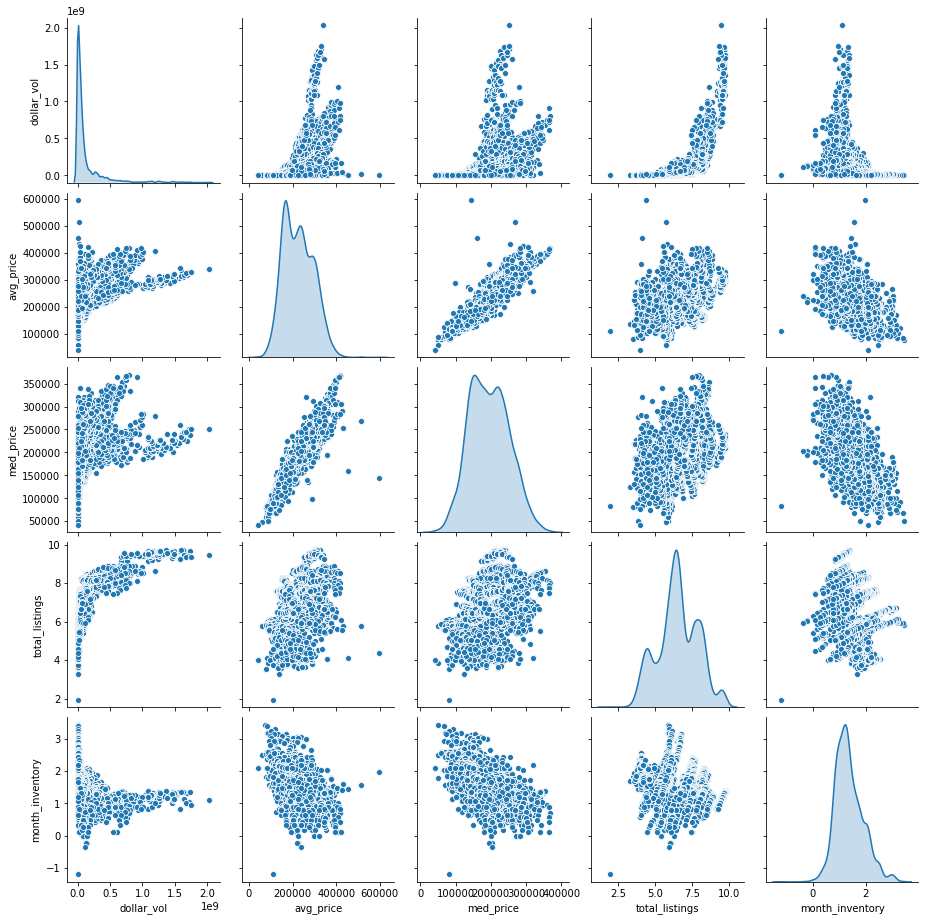

In [51]:
## basic exploratory plots
import seaborn as sns

sns.pairplot(train[features], diag_kind = 'kde')

**Rolling Regressions** are one of the simplest models for analysing changing relationships among variables overtime. They use linear regression but allow the data set used to change over time. In most linear regression models, parameters are assumed to be time-invariant and thus should not change overtime. Rolling regressions estimate model parameters using a fixed window of time over the entire data set. A larger sample size, or window, used will result in fewer parameter estimates but use more observations. 

**Recursive Rolling Regression**; A rolling regression with an expanding (rather than moving) window is effectively a recursive least squares model. We start with our desired window size, and add data as we expand outwards; usually capture the whole dataset 

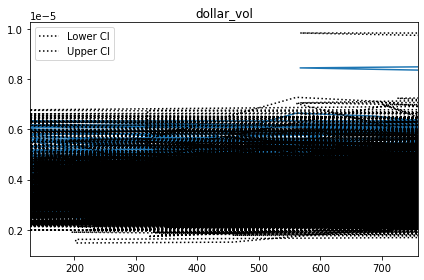

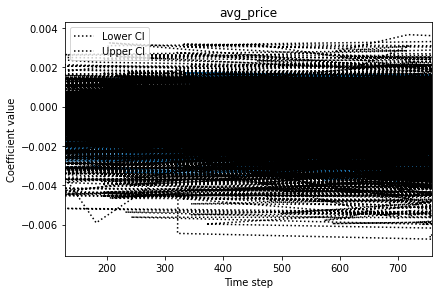

In [58]:
## Rolling regression with differing window sizes
from statsmodels.regression.rolling import RollingOLS
from statsmodels.datasets import longley
import statsmodels.api as sm

## '-1' argument supresses model estimate for intercept
roll_reg = RollingOLS.from_formula('sales ~ dollar_vol + avg_price', 
    window = 10, data = train) 
model = roll_reg.fit()

fig = model.plot_recursive_coefficient(variables=['dollar_vol'])
fig = model.plot_recursive_coefficient(variables=['avg_price'])
plt.xlabel('Time step')
plt.ylabel('Coefficient value')
plt.show()

/Users/andrewma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Text(0.5, 1.0, 'Coefficient value')

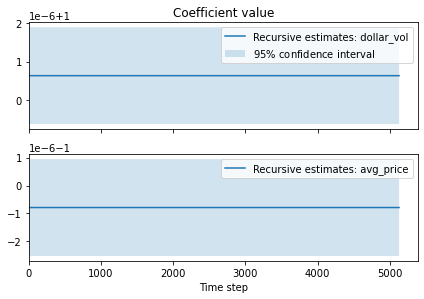

In [59]:
## Recursive ordinary least squares (expanding window rolling regression)
reg_rls = sm.RecursiveLS.from_formula(
    'sales ~ dollar_vol + avg_price -1', df)
model_rls = reg_rls.fit()
#print(model_rls.summary())

fig = model_rls.plot_recursive_coefficient(range(reg_rls.k_exog), legend_loc='upper right')
ax_list = fig.axes
for ax in ax_list:
    ax.set_xlim(0, None)
ax_list[-1].set_xlabel('Time step')
ax_list[0].set_title('Coefficient value')

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

To acquire better estimates for these above variables, we'll implement a basic AR function before adding on

In [47]:
## ARIMA(Autoregressive Integrated Moving Average) implementation
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

Generalized Additive Models

If the data is having a nonlinear effect, in such a case we use GAM. Linearity in models means that the changes of one unit in predictors can cause the same effect on the outcome of the model. If at some point, changes in feature not affecting the outcome or impacting oppositely, we can say that there is a nonlinearity effect in the data.

For this section, we will explore the possibiltiy that the some of the relationships between our response & predictors follow a nonlinear relationship.

In [262]:
## Generalized Additive Models (GAM)
## Generalized Additive Models allow for penalized estimation of smooth terms in generalized linear models
from pygam import LinearGAM, s, f


On the utilziation of Neural Nets for Time Series Regression

Our estimators here vary wildly in terms of weights - I suspect a variation of neural nets to be able to acqure better weight estiamtes for these coefficients

In [71]:
## Neural Networks for Regression

## basic model with one covariate
horsepower = np.array(X_train['avg_price'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])
horsepower_model.summary()

#make predictions
horsepower_model.predict(horsepower[:10])

horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_16 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


UsageError: Line magic function `%%time` not found.


In [79]:
history = horsepower_model.fit(
    X_train['avg_price'],
    X_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,4.423455,4.429850,95
96,4.422770,4.429801,96
97,4.424267,4.430569,97
98,4.423326,4.429849,98
99,4.423064,4.429801,99


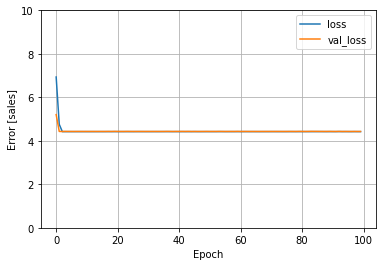

In [82]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [sales]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [72]:
## NN Linear Regression w/ Multiple Inputs


UsageError: Line magic function `%%time` not found.


Comparison between Methods